# Generation of Synthetic Clinical Datasets

## Methodology
- Method of data generation
	- LLM is given a prompt to generate a clinical case based on a diagnosis or group of symptoms. URTI.
  - Demographic characteristics are inputs which can be adjusted for clinical note generation across a diverse population cohort.

Hass Inputs on generation variation: India vs US hospital, IMG vs Hopkins graduate, CMS vs private insurance, patient on medicaid vs blue shield (SDOH)
Check 

  - Clinical note generation is referenced to a realistic clinical note. Equivalent to a one shot learning.
- Validation
  - Generated clinical note is vetted and modified by a panel of 3 independent physicians. If there are any differences in opinion between the clinicians, a third clinician's opinion is sought.
  - Validation criteria used by independent physicians:
    - Are cases clinically correct? E.g. An erroneous clinical case would be a patient with chest pain and shortness of breadth was diagnosed with stroke instead.
    - Are cases clinically realistc? E.g. An unrealistic clinical case would be a patient, with URTI symptoms and no other complications, who was admitted to hospital for 2 weeks. 
    - Are cases appropriate for intended clinical use case of LLM? E.g. An inappropriate clinical case would be, when the intended output for the LLM is an outpatient consult, a referral note is generated instead.
    - Are there any hallucinations?
  - Annotation by clinician to improve quality of synthetic clinical cases

Hass inputs on validity: Temporal progression, detailed documentation of physical exam findings, clinical and biological plausibility, available lab and medical imaging results. Structured template chief complaint, HOPC, past medical history, medications and allergy, review of systems, initial labs, image findings.

- Testing
	- When testing multiple datasets against the synthetic clinical dataset, the original model used to generate the clinical dataset should be omitted.

Cutoff on when we can accept the synthetic datasets (Might be more than 80%)


## Plan

Planned datasets:
1. Cardiology
2. Neurology
3. Emergency department

## Evaluation metrics for labels
1. Accuracy (Currently used by Med Gemini team https://research.google/blog/advancing-medical-ai-with-med-gemini/ )
2. Sensitivity
3. Specificity
4. PPV
5. NPV
6. AUROC
7. AUPRC

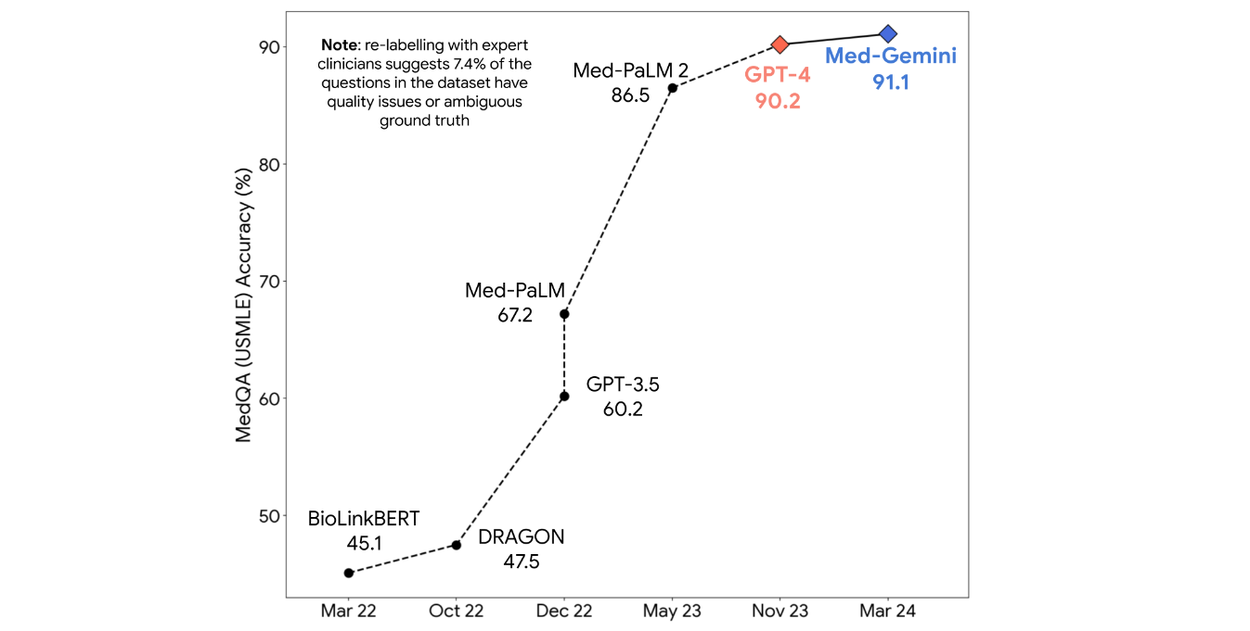

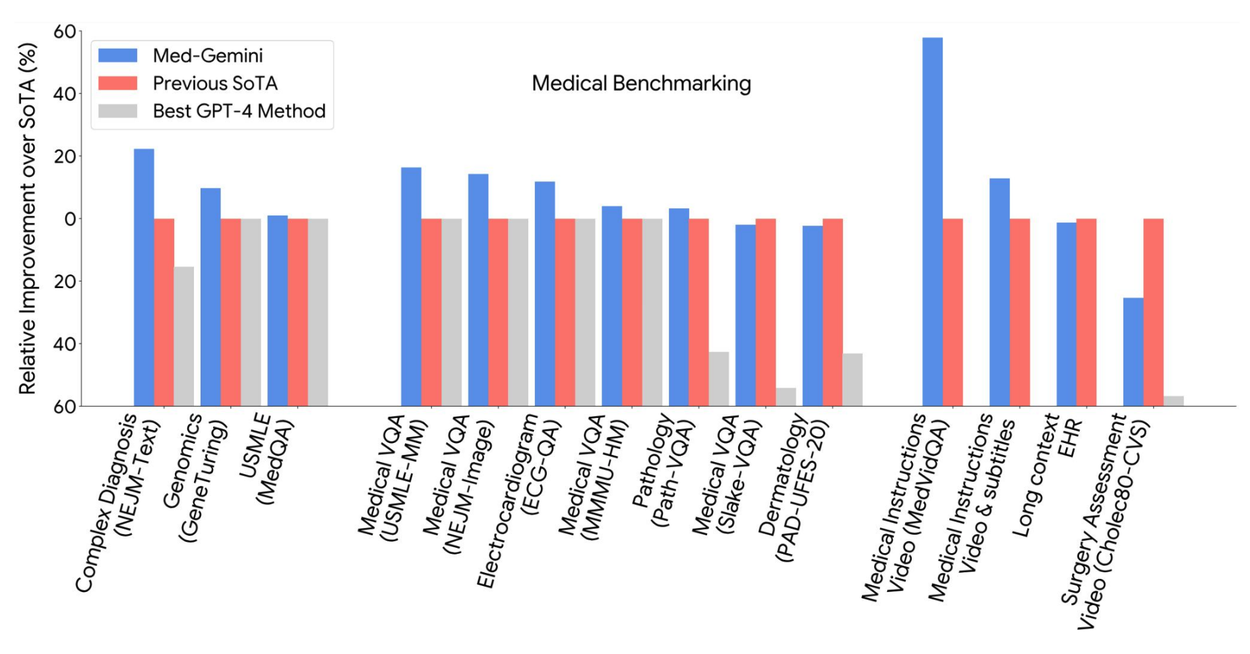

## 
 

In [2]:
# Code to load GPT

# Load openai API key from dotenv
from dotenv import load_dotenv

load_dotenv()

# Load OpenAI model
from langchain_openai import ChatOpenAI

llm = ChatOpenAI(model="gpt-4o", temperature=0)

In [3]:
# RAG with UpToDate Diabetes Example (Custom Langchain Prompt)

template = '''
You are a medical expert writing a realistic case note with only history and physical exam findings, 
based on the patient type and diagnosis provided. 
You will write the case note using the same format as the case note example provided. 

Patient type: {patient_type}

Diagnosis: {diagnosis}

Case note example: {case_note_example}

Case note:"
'''

case_note_example = '''
55 year old Chinese male
NKDA

===Past Medical History===
1. HTN
2. DM
3. HLD
4. HF (EF 40% last done on 2021)

===HOPC===
Vertiginous dizziness x 1/7
A/w headache
No weakness
No sensory deficits
No visual deficits
No fever
No nausea / vomiting
No tinnitus
Able to walk

o/e
Vitals 
BP 130/80
HR 80
RR 16
T 36.8
H S1 S2 no murmur
L clear no creps
A soft non tender BS present
CN 2-12 intact
No focal neurological deficits
No cerebellar signs
Possible nystagmus

===Investigations===
CT brain 2019 - normal
FBC UEC LFTs normal

===Assessment===
Vertigo

===Plan===
MRI brain

ENT review
Neurology review
Betahistadine 16mg TDS
'''

In [4]:
from langchain_core.prompts.chat import ChatPromptTemplate

diagnosis = "Acute chest pain with a diagnosis of GERD"
patient_type = "Elderly patient"

prompt = ChatPromptTemplate.from_template(template)


In [5]:
chain = (
  prompt | llm
)

answer = chain.invoke({"diagnosis": diagnosis, "patient_type": patient_type, "case_note_example": case_note_example})

print(answer.content)

78 year old Caucasian female  
NKDA  

===Past Medical History===  
1. Osteoarthritis  
2. Hypertension  
3. Chronic kidney disease (Stage 3)  
4. Hypothyroidism  

===HOPC===  
Acute chest pain x 2/7  
A/w burning sensation in the chest  
No radiation to arm or jaw  
No shortness of breath  
No diaphoresis  
No nausea / vomiting  
No palpitations  
Symptoms worsen after meals and when lying down  

o/e  
Vitals  
BP 140/85  
HR 78  
RR 18  
T 37.0  
H S1 S2 no murmur  
L clear no creps  
A soft non tender BS present  
Abdomen soft, non-distended, mild epigastric tenderness  
No guarding or rebound tenderness  
No peripheral edema  

===Investigations===  
ECG - normal sinus rhythm, no ischemic changes  
Troponin - negative  
FBC UEC LFTs - within normal limits  

===Assessment===  
Acute chest pain secondary to GERD  

===Plan===  
Start omeprazole 20mg daily  
Lifestyle modifications: elevate head of bed, avoid late meals, reduce caffeine and spicy foods  
Follow-up in 2 weeks  
Cons

In [ ]:
import pandas as pd

def generate_data(permutations):
  columns=["diagnosis", "patient_type", "case_note_example", "case_note"]
  generated_data = pd.DataFrame(columns=columns)

  def create_new_entry(diagnosis, patient_type, case_note_example, generated_data):
    answer = chain.invoke({"diagnosis": diagnosis, "patient_type": patient_type, "case_note_example": case_note_example})
    # print("Generated Note: ", answer)
    new_row = pd.DataFrame([[diagnosis, patient_type, case_note_example, answer]], columns=columns)
    generated_data = pd.concat([generated_data, new_row], ignore_index=True)

    return generated_data

  for permutation in permutations:
    print("Patient type: ", permutation["Patient Type"])
    print("Diagnosis: ", permutation["Diagnosis"])
    for i in range(permutation["iterations"]):
      print("Iteration: ", i)
      generated_data = create_new_entry(permutation['Diagnosis'], permutation['Patient Type'], case_note_example, generated_data)
    print("")
  
  return generated_data

permutations = [
  {"Patient Type": "male young patient", "Diagnosis": "Acute Chest Pain with a diagnosis of GERD", "iterations": 10},
  {"Patient Type": "male adult patient", "Diagnosis": "Acute Chest Pain with a diagnosis of GERD", "iterations": 10},
  {"Patient Type": "male elderly patient", "Diagnosis": "Acute Chest Pain with a diagnosis of GERD", "iterations": 10},
  {"Patient Type": "female young patient", "Diagnosis": "Acute Chest Pain with a diagnosis of GERD", "iterations": 10},
  {"Patient Type": "female adult patient", "Diagnosis": "Acute Chest Pain with a diagnosis of GERD", "iterations": 10},
  {"Patient Type": "female elderly patient", "Diagnosis": "Acute Chest Pain with a diagnosis of GERD", "iterations": 10},
]

generated_data = generate_data(permutations)